In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn.objects as so
import os
import io
import re

import random

random.seed(42)
np.random.seed(42)
mpl.rcParams['svg.hashsalt'] = '42'

In [2]:
# set fixed order of elements in graphs
optimization_order = ['disabled', 'enabled']
service_mesh_order = ['none', 'cilium', 'istio-ambient', 'istio-sidecar']

In [3]:
def set_index_order(df):
    df = df.copy()
    df = df.reindex(pd.MultiIndex.from_tuples([ (a, b) for a in service_mesh_order for b in optimization_order], names=['Service Mesh', 'Mode']))
    df.index = pd.MultiIndex.from_tuples([ (a, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'}[b]) for (a, b) in df.index.to_numpy()], names=['Service Mesh', 'Mode'])
    return df

In [4]:
def update_legend(g, mapping):
    for text in g.get_legend().get_texts():
        text.set(text=mapping[text.get_text()])

In [5]:
def count_decimal_places(num, remove_single_zero=False):
    str_num = str(num)
    if remove_single_zero and str_num.endswith('.0'):
        return 0
    if '.' in str_num:
        return len(str_num) - str_num.index('.') - 1
    else:
        return 0

In [6]:
def float_format(x, remove_single_zero=True):
    return '{:.{}f}'.format(x, min(count_decimal_places(x, remove_single_zero=remove_single_zero), pd.get_option('display.precision')))

In [7]:
def format_data_size(number, from_unit, to_unit, remove_single_decimal_zero=True):
    convert_table = {
        'B': 1,
        'K': 1000,
        'M': 1000 ** 2,
        'G': 1000 ** 3,
        'T': 1000 ** 4,
        'P': 1000 ** 5,
    }
    if from_unit[-1] == 'B' and to_unit[-1] == 'b':
        number *= 8
    if from_unit[-1] == 'b' and to_unit[-1] == 'B':
        number /= 8
    number *= convert_table[from_unit[0].upper()]
    number /= convert_table[to_unit[0].upper()]
    #return float_format(number, remove_single_decimal_zero)
    return number

In [8]:
def format_time(number, from_unit, to_unit, remove_single_decimal_zero=True):
    convert_table = {
        'ns': 1,
        'us': 10 ** 3,
        'ms': 10 ** 6,
         's': 10 ** 9,
    }
    number *= convert_table[from_unit]
    number /= convert_table[to_unit]
    #return float_format(number, remove_single_decimal_zero)
    return number

In [9]:
pd.set_option('display.precision', 1)
#pd.set_option('display.float_format', float_format)
pd.set_option('display.max_columns', None)

In [10]:
def summary_value(df, metric, *, col=None, index=None):
    df = df.copy()
    metric_float = df[metric].astype(float)
    df[metric] = df[metric].map(float_format)
    df['percent'] = (metric_float / metric_float.shift() * 100 - 100).map(float_format)
    df['percent'] = df.apply(lambda x: x.percent if (x[col] if col else x.name[index]) == 'enabled' else pd.NA, 1)
    df['value'] = df.apply(lambda x: x[metric] + (f' ({x.percent}%)' if not pd.isna(x.percent) else ''), 1)
    del df['percent']
    return df

In [11]:
def print_latex(df):
    df = df.copy()
    df.index = pd.MultiIndex.from_tuples([(f'\\textit{{{a}}}' if a == 'none' else f'\\texttt{{{a}}}', b) for (a, b) in df.index], names=['Service Mesh', 'Mode'])
    df = df.map(lambda value: re.sub(r'\((.*?)\)', lambda match: f'(\\textbf{{{match.group(1)}}})', value.replace('%', '\\%')))
    print(df.to_latex(float_format=float_format))

In [12]:
import os
import re
import zipfile
from pprint import pprint


def logs_processing(basepath='.'):
    files = os.listdir(basepath)
    logs_zip_pattern = re.compile(r'logs_.*\.zip')
    logs_zip_files = [f for f in files if logs_zip_pattern.match(f)]

    workload_log_map = {
        'ping': 'ping-echo',
        'client': 'file-transfer',
        'memtier': 'redis',
    }

    system_logs = []
    workload_logs = {}

    for zip_filename in logs_zip_files:
        zip_filename_components = zip_filename.split('.')[0].split('_')

        if len(zip_filename_components) != 4: continue

        _, cni, service_mesh, optimization = zip_filename_components

        with zipfile.ZipFile(os.path.join(basepath, zip_filename), 'r') as zip_ref:
            for file in zip_ref.infolist():
                if file.is_dir(): continue

                entry = { 'cni': cni, 'service_mesh': service_mesh, 'optimization': optimization, 'workload': None, 'data': None, 'meta': {} }

                filename = file.filename.replace(r'mnt/logs/', '')

                ###################
                ### system logs ###
                ###################

                ### statexec
                if filename.startswith('statexec_metrics'):
                    entry['workload'] = filename.split('_')[2]

                    if entry['workload'] not in workload_log_map.values(): continue

                    data = zip_ref.read(file).decode('utf-8')
                    statexec_pattern = re.compile(r'(?P<metric>.*){(?P<params>.*?)} (?P<value>.+) (?P<timestamp>\d+)')
                    statexec_param_pattern = re.compile(r',?(?P<k>.*?)="(?P<v>.*?)"')
                    data = [statexec_pattern.match(line).groupdict() for line in data.split('\n') if line != '' and line[0] != '#']
                    data = [{**value, 'params': { k: v for (k, v) in statexec_param_pattern.findall(value['params']) if k not in ['instance', 'job', 'role', 'cni', 'optimization', 'service_mesh'] } } for value in data ]
                    entry['data'] = data

                    system_logs.append(entry)
                    continue


                #####################
                ### workload logs ###
                #####################

                entry['workload'] = workload_log_map.get(filename.split('/')[0], None)

                if entry['workload'] == 'ping-echo':
                    data = zip_ref.read(file).decode('utf-8')
                    entry['data'] = data

                elif entry['workload'] == 'file-transfer':
                    data = zip_ref.read(file).decode('utf-8')
                    values = re.findall(r'Ncat: \d+ bytes sent, \d+ bytes received in (\d+.\d+) seconds\.', data)
                    entry['data'] = [float(v) * (10 ** 9) for v in values]

                elif entry['workload'] == 'redis':
                    if filename.endswith('/log.txt'):
                        entry['meta'] = { 'type': 'metrics' }
                        data = zip_ref.read(file).decode('utf-8')
                        data = data.replace(r'Connection error: Connection refused', '')
                        redis_log_pattern = re.compile(r'\[RUN #(?P<iteration>\d+) 100%, *(?P<took>\d+) secs\] *0 threads: *\d+ ops, *\d+ \(avg: *(?P<ops_avg>\d+)\) ops\/sec, *\d+.\d+[KMG]B\/sec \(avg: *(?P<throughput_avg>\d+.\d+[KMG]B)\/sec\), *\d+.\d+ \(avg: *(?P<latency_avg>\d+.\d+)\) msec latency')
                        values = [match.groupdict() for match in redis_log_pattern.finditer(data)]
                        for value in values:
                            # took is in s. transform to ns
                            value['took'] = int(value['took']) * (10 ** 9)

                            # latency_avg is in ms. transform to ns
                            value['latency_avg'] = float(value['latency_avg']) * (10 ** 6)

                            # throughput_avg is in KB, MB, GB. transform to bits
                            # https://github.com/RedisLabs/memtier_benchmark/blob/2.1.2/memtier_benchmark.cpp#L1121
                            B = float(value['throughput_avg'][:-2])
                            # memtier uses 1024 to multiply between units KB, MB, GB. transform to bytes
                            unit = value['throughput_avg'][-2:]
                            if unit == 'GB':
                                B *= 1024 ** 3
                            elif unit == 'MB':
                                B *= 1024 ** 2
                            elif unit == 'KB':
                                B *= 1024
                            # memtier uses bytes. transform to bits
                            B *= 8
                            value['throughput_avg'] = B
                        entry['data'] = values
                    else:
                        match = re.match(r'_FULL_RUN_(?P<iteration>\d+)\.txt$', filename.split('/')[-1])

                        if not match: continue

                        iteration = match.group('iteration')
                        entry['meta'] = { 'type': 'histogram', 'iteration': iteration }
                        data = zip_ref.read(file).decode('utf-8')
                        entry['data'] = '\n'.join([line for line in data.split('\n') if line != '' and line[0] != '#'][:-1])

                ### UNKNOWN
                else:
                    continue

                if entry['workload'] not in workload_logs:
                    workload_logs[entry['workload']] = []

                workload_logs[entry['workload']].append(entry)

    return { 'system_logs': system_logs, 'workload_logs': workload_logs }

In [13]:
logs = logs_processing('../workloads/')

# system-logs

In [14]:
system_logs = pd.DataFrame(logs['system_logs'])
del system_logs['meta']
system_logs = system_logs.explode('data').apply(lambda x: pd.concat([x.drop('data'), pd.json_normalize(x.data, sep='_').iloc[0]]), axis=1)
system_logs = system_logs.astype({'timestamp': 'int64', 'value': 'float64'}).sort_values(by='timestamp', ignore_index=True)
system_logs.drop_duplicates(inplace=True, ignore_index=True)

In [15]:
system_logs.head()

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload
0,calico,statexec_cpu_seconds_total,disabled,cpu2,NaN,NaN,guestNice,none,1736354149117,0.0,ping-echo
1,calico,statexec_cpu_seconds_total,disabled,cpu3,NaN,NaN,steal,none,1736354149117,12.6,ping-echo
2,calico,statexec_cpu_seconds_total,disabled,cpu3,NaN,NaN,nice,none,1736354149117,0.0,ping-echo
3,calico,statexec_cpu_seconds_total,disabled,cpu3,NaN,NaN,iowait,none,1736354149117,10.5,ping-echo
4,calico,statexec_cpu_seconds_total,disabled,cpu0,NaN,NaN,guestNice,none,1736354149117,0.0,ping-echo


In [16]:
sorted(system_logs.metric.unique())

['statexec_command_status',
 'statexec_cpu_seconds_total',
 'statexec_disk_read_bytes_total',
 'statexec_disk_write_bytes_total',
 'statexec_memory_available_bytes',
 'statexec_memory_buffers_bytes',
 'statexec_memory_cached_bytes',
 'statexec_memory_free_bytes',
 'statexec_memory_total_bytes',
 'statexec_memory_used_bytes',
 'statexec_memory_used_percent',
 'statexec_metric_collect_duration_ms',
 'statexec_network_received_bytes_total',
 'statexec_network_sent_bytes_total',
 'statexec_statexec_time_since_start_ms',
 'statexec_summary_cpu_cores',
 'statexec_summary_cpu_mean_seconds',
 'statexec_summary_disk_mean_read_bytes_per_second',
 'statexec_summary_disk_mean_write_bytes_per_second',
 'statexec_summary_memory_buffers_bytes',
 'statexec_summary_memory_cached_bytes',
 'statexec_summary_memory_free_bytes',
 'statexec_summary_memory_total_bytes',
 'statexec_summary_memory_used_bytes',
 'statexec_summary_network_mean_received_bytes_per_second',
 'statexec_summary_network_mean_sent_byte

In [17]:
sorted(system_logs[system_logs.metric.eq('statexec_cpu_seconds_total')].params_mode.unique())

['guest',
 'guestNice',
 'idle',
 'iowait',
 'irq',
 'nice',
 'softirq',
 'steal',
 'system',
 'user']

In [18]:
system_logs.timestamp.diff().abs().sort_values(ascending=False)[:25]

221143    670820.0
48701     560888.0
161321    223197.0
247309    206336.0
109809    169805.0
28990     162593.0
198667    114497.0
128389     72959.0
77489      64614.0
85245      61756.0
8774       57659.0
212417     56690.0
35104      53272.0
182901     52617.0
15744      52473.0
260088     51878.0
40701      50751.0
237321     50576.0
230215     50260.0
173231     48196.0
253794     47918.0
135705     47002.0
206037     46529.0
41639       1000.0
223655      1000.0
Name: timestamp, dtype: float64

In [19]:
system_logs['x'] = (system_logs.timestamp.diff().abs().gt(40_000).cumsum() + 1).astype(str)
start_point = system_logs.groupby('x')['timestamp'].transform(lambda x: x.min())
system_logs['elapsed'] = system_logs.timestamp - start_point

In [20]:
cpu_seconds_cum = system_logs[
    (system_logs['metric'] == 'statexec_cpu_seconds_total') &
    (system_logs['params_mode'].isin(['user', 'system']))
].groupby(['workload', 'service_mesh', 'optimization', 'timestamp', 'elapsed'])['value'].sum().reset_index()

cpu_seconds_cum

,workload,service_mesh,optimization,timestamp,elapsed,value
0,file-transfer,cilium,disabled,1736359323695,0,461.0
1,file-transfer,cilium,disabled,1736359323696,1,461.0
2,file-transfer,cilium,disabled,1736359324695,1000,463.1
3,file-transfer,cilium,disabled,1736359325695,2000,463.6
4,file-transfer,cilium,disabled,1736359326695,3000,464.4
...,...,...,...,...,...,...
3032,redis,none,enabled,1736355072865,87000,1871.8
3033,redis,none,enabled,1736355072940,87075,1872.0
3034,redis,none,enabled,1736355073865,88000,1872.4
3035,redis,none,enabled,1736355074865,89000,1873.0


In [21]:
cpu_seconds_usage = cpu_seconds_cum.groupby(['workload', 'service_mesh', 'optimization'])['value'].agg(
    value=lambda x: np.ptp(x),
).reset_index()

cpu_seconds_usage

,workload,service_mesh,optimization,value
0,file-transfer,cilium,disabled,83.4
1,file-transfer,cilium,enabled,82.8
2,file-transfer,istio-ambient,disabled,103.0
3,file-transfer,istio-ambient,enabled,90.1
4,file-transfer,istio-sidecar,disabled,100.7
5,file-transfer,istio-sidecar,enabled,114.5
6,file-transfer,none,disabled,86.4
7,file-transfer,none,enabled,81.4
8,ping-echo,cilium,disabled,104.9
9,ping-echo,cilium,enabled,92.3


In [22]:
memory_used_bytes = system_logs[system_logs.metric.eq('statexec_memory_used_bytes')]
memory_used_bytes

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload,x,elapsed
39,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354149117,1.3e+09,ping-echo,1,0
121,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354149120,1.3e+09,ping-echo,1,3
212,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354150117,1.4e+09,ping-echo,1,1000
296,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354151117,1.3e+09,ping-echo,1,2000
399,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354152117,1.3e+09,ping-echo,1,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267987,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360087403,1.4e+09,redis,24,86000
268053,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360087689,1.3e+09,redis,24,86286
268142,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360088403,1.3e+09,redis,24,87000
268234,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736360089403,1.3e+09,redis,24,88000


# file-transfer

In [23]:
file_transfer = pd.DataFrame(logs['workload_logs']['file-transfer'])
del file_transfer['meta']
file_transfer.rename(columns={'data': 'took'}, inplace=True)
file_transfer = file_transfer.explode('took', ignore_index=True).astype({'took': 'int64'})

In [24]:
file_transfer.head()

,cni,service_mesh,optimization,workload,took
0,calico,istio-ambient,disabled,file-transfer,10660000000
1,calico,istio-ambient,disabled,file-transfer,10860000000
2,calico,istio-ambient,disabled,file-transfer,10590000000
3,calico,istio-ambient,disabled,file-transfer,10350000000
4,calico,istio-ambient,disabled,file-transfer,10440000000


In [25]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25     p50     avg     p75
Service Mesh  Mode                                    
none          Baseline  1354.9  1368.1  1368.0  1379.7
              eSeMeshA  1381.6  1392.9  1392.0  1401.6
cilium        Baseline  1283.2  1291.1  1292.7  1302.4
              eSeMeshA  1327.3  1332.5  1332.5  1337.0
istio-ambient Baseline  1632.2  1647.5  1644.8  1656.8
              eSeMeshA  1650.8  1659.0  1660.2  1669.3
istio-sidecar Baseline  1614.2  1626.5  1625.4  1637.5
              eSeMeshA  1648.9  1660.2  1668.6  1689.6

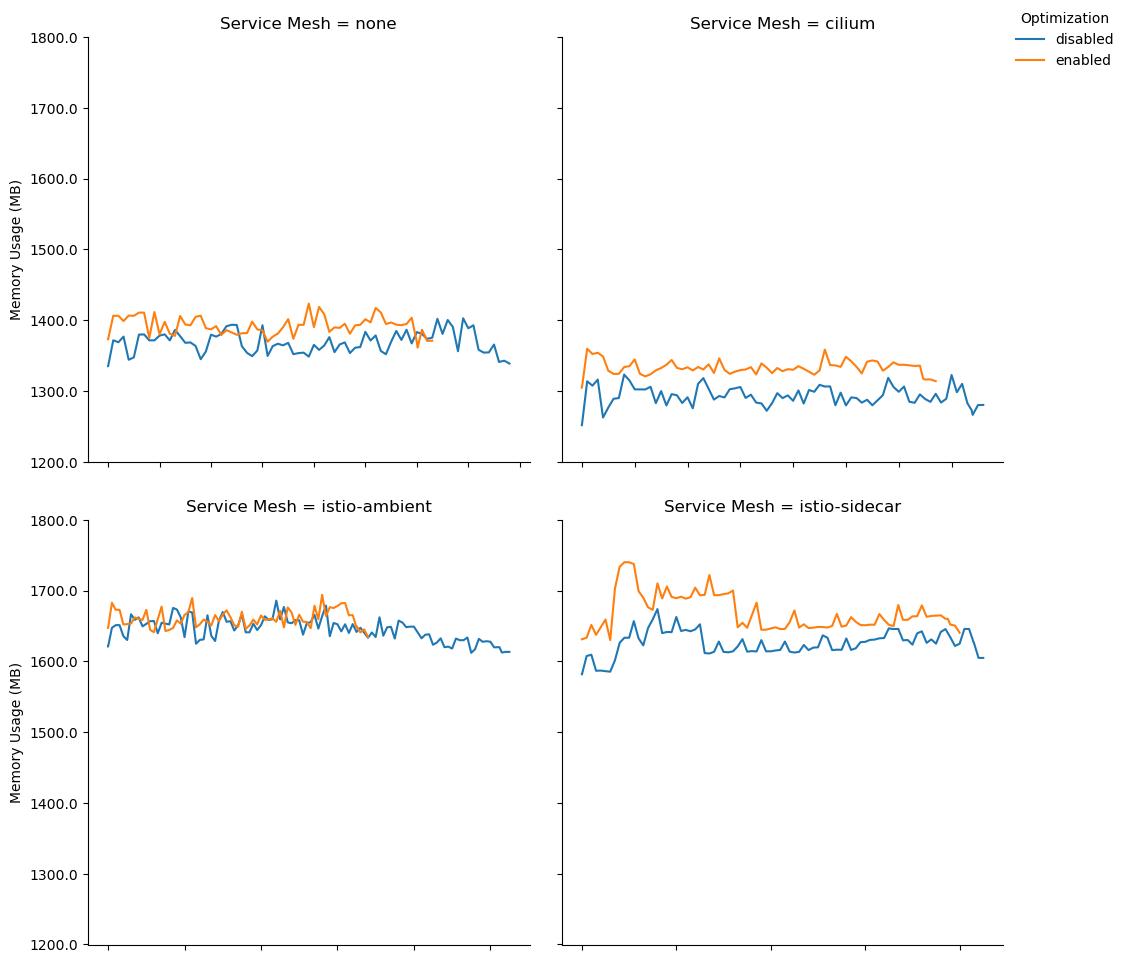

In [26]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')], y='value', x='elapsed', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage (MB)',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Optimization', loc='upper right')
#g.get_legend().set_visible(False)
g.figure.savefig('file-transfer-relplot-line-memory-used-bytes.svg', bbox_inches='tight', metadata={'Date': None})

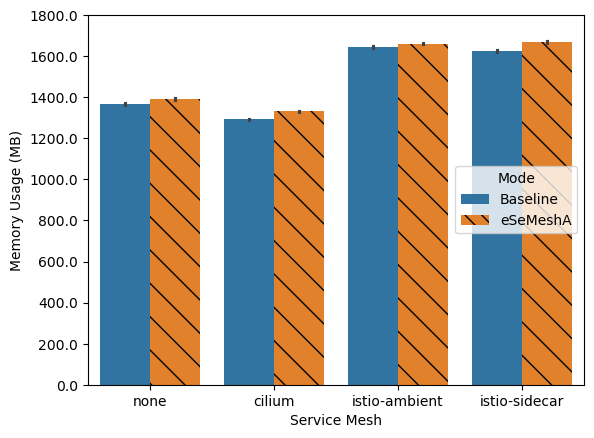

In [27]:
g = sns.barplot(data=memory_used_bytes[memory_used_bytes.workload.eq('file-transfer')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Memory Usage (MB)',
    yticklabels=[format_data_size(tick, 'B', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='center right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('file-transfer-barplot-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [28]:
summary = file_transfer.groupby(['service_mesh', 'optimization'])['took'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25   p50   avg   p75
Service Mesh  Mode                            
none          Baseline  10.5  10.5  10.6  10.7
              eSeMeshA   8.3   8.3   8.4   8.4
cilium        Baseline   9.3   9.5   9.5   9.6
              eSeMeshA   8.3   8.4   8.4   8.4
istio-ambient Baseline  10.4  10.6  10.6  10.7
              eSeMeshA   8.4   8.5   8.4   8.5
istio-sidecar Baseline   6.8   6.9   6.9   6.9
              eSeMeshA   8.2   8.3   8.4   8.5

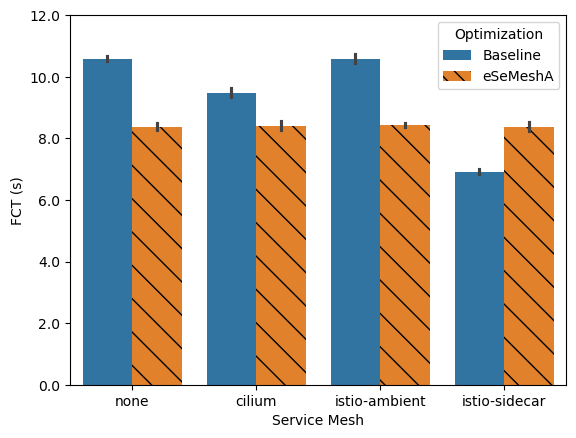

In [29]:
g = sns.barplot(data=file_transfer, y='took', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT (s)',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

g.legend(title='Optimization', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('file-transfer-barplot-fct.svg', bbox_inches='tight', metadata={'Date': None})

# ping-echo

In [30]:
ping_echo = pd.DataFrame(logs['workload_logs']['ping-echo'])
del ping_echo['meta']
ping_echo = ping_echo.apply(lambda x: x.drop('data').to_frame().T.join(pd.read_csv(io.StringIO(x.data)), how='cross'), axis=1)
ping_echo = pd.concat(ping_echo.tolist(), ignore_index=True)
ping_echo['latency'] = ping_echo['end'] - ping_echo['start']
ping_echo['throughput'] = (24 * 1e9) / ping_echo['latency']
ping_echo['RPS'] = 1e9 / ping_echo['latency']

In [31]:
ping_echo.head()

,cni,service_mesh,optimization,workload,run,start,end,latency,throughput,RPS
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357548673984875,521212,46046.5,1918.6
1,calico,istio-ambient,disabled,ping-echo,0,1736357548674001489,1736357548674170968,169479,141610.5,5900.4
2,calico,istio-ambient,disabled,ping-echo,0,1736357548674179030,1736357548674310892,131862,182008.5,7583.7
3,calico,istio-ambient,disabled,ping-echo,0,1736357548674326890,1736357548674448536,121646,197293.8,8220.6
4,calico,istio-ambient,disabled,ping-echo,0,1736357548674453871,1736357548674564736,110865,216479.5,9020.0


In [32]:
grouped = ping_echo.groupby(['cni', 'service_mesh', 'optimization', 'workload', 'run'])
ping_echo_extra = grouped.agg(start_min=('start', 'min'), end_max=('end', 'max'))
ping_echo_extra['fct'] = ping_echo_extra['end_max'] - ping_echo_extra['start_min']
ping_echo_extra['jitter'] = grouped[['latency']].std(ddof=0)
ping_echo_extra.reset_index(inplace=True)

In [33]:
ping_echo_extra.head()

,cni,service_mesh,optimization,workload,run,start_min,end_max,fct,jitter
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357563293586211,14620122548,108852.8
1,calico,istio-ambient,disabled,ping-echo,1,1736357565295443961,1736357580060699877,14765255916,99831.8
2,calico,istio-ambient,disabled,ping-echo,2,1736357582062233676,1736357596750912885,14688679209,93902.5
3,calico,istio-ambient,disabled,ping-echo,3,1736357598752148818,1736357613694342945,14942194127,102313.2
4,calico,istio-ambient,disabled,ping-echo,4,1736357615696592734,1736357630437159373,14740566639,103280.0


In [34]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25     p50     avg     p75
Service Mesh  Mode                                    
none          Baseline  1373.6  1382.6  1380.2  1387.6
              eSeMeshA  1404.5  1414.5  1411.4  1422.1
cilium        Baseline  1316.8  1325.1  1325.7  1334.6
              eSeMeshA  1345.5  1350.9  1352.4  1360.6
istio-ambient Baseline  1652.2  1662.5  1660.7  1673.6
              eSeMeshA  1670.0  1679.3  1677.7  1689.7
istio-sidecar Baseline  1636.2  1650.7  1645.7  1661.6
              eSeMeshA  1663.0  1670.7  1667.6  1678.0

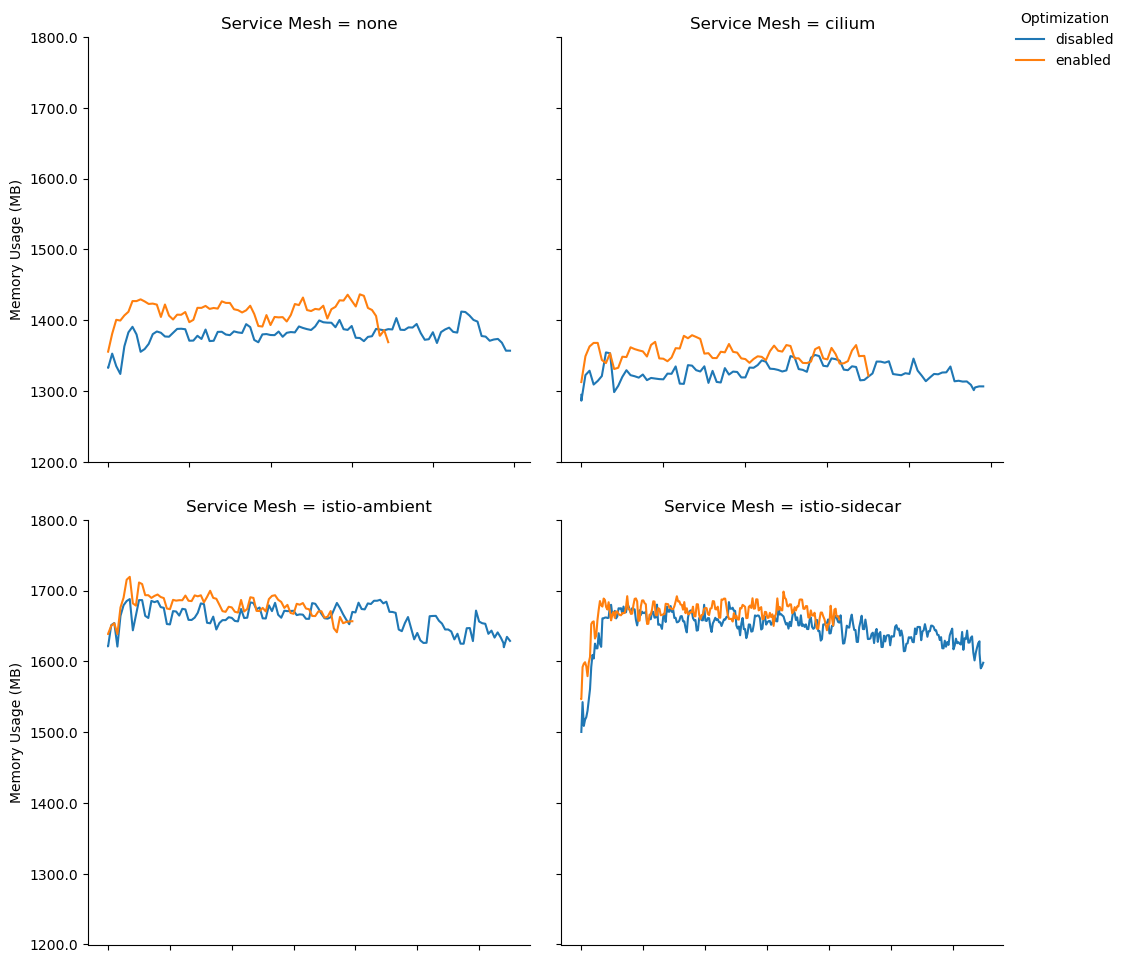

In [35]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')], y='value', x='elapsed', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage (MB)',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Optimization', loc='upper right')
#g.get_legend().set_visible(False)
g.figure.savefig('ping-echo-relplot-line-memory-used-bytes.svg', bbox_inches='tight', metadata={'Date': None})

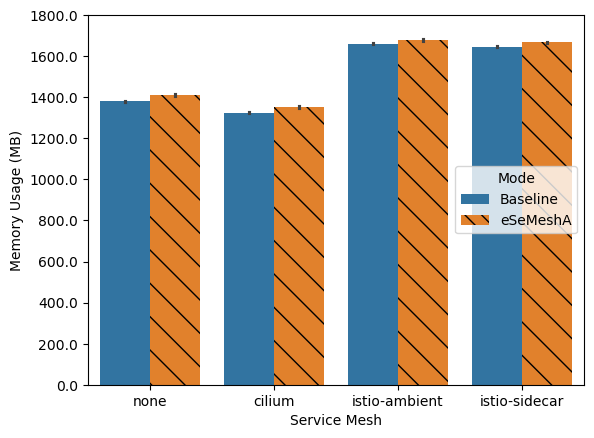

In [36]:
g = sns.barplot(data=memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Memory Usage (MB)',
    yticklabels=[format_data_size(tick, 'B', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='center right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [37]:
summary = cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])[['value']].first()
summary = set_index_order(summary)

summary
#print_latex(summary)

value
Service Mesh  Mode           
none          Baseline  110.5
              eSeMeshA   92.6
cilium        Baseline  104.9
              eSeMeshA   92.3
istio-ambient Baseline  132.2
              eSeMeshA  103.2
istio-sidecar Baseline  357.8
              eSeMeshA  274.7

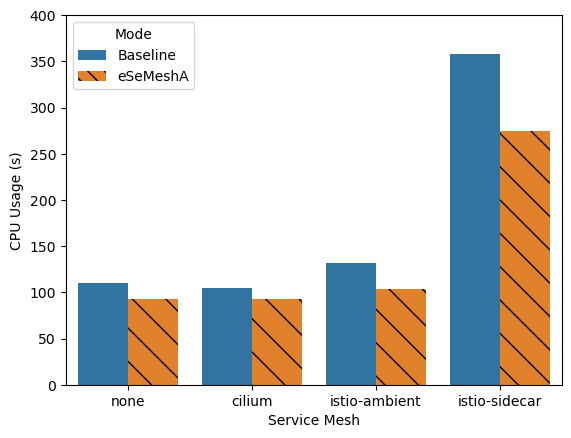

In [38]:
g = sns.barplot(data=cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='CPU Usage (s)',
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-cpu-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [39]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['RPS'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25      p50      avg      p75
Service Mesh  Mode                                        
none          Baseline   6338.0   8238.7   8186.1  10240.6
              eSeMeshA  10260.2  13600.8  13104.6  16514.2
cilium        Baseline   7447.3   9803.7   9685.2  12055.0
              eSeMeshA  10275.5  13541.5  13058.0  16422.5
istio-ambient Baseline   6303.4   8196.4   8172.3  10124.0
              eSeMeshA  10385.2  13808.1  13274.4  16728.0
istio-sidecar Baseline   1625.3   2017.9   2049.1   2459.8
              eSeMeshA   2781.4   3479.5   3502.1   4235.2

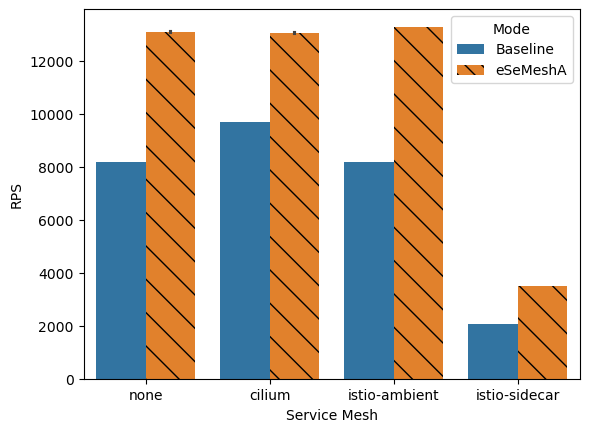

In [40]:
g = sns.barplot(data=ping_echo, y='RPS', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set(
    xlabel='Service Mesh',
    ylabel='RPS',
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-rps.svg', bbox_inches='tight', metadata={'Date': None})

In [41]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['throughput'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'b', 'KB'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25   p50   avg   p75
Service Mesh  Mode                            
none          Baseline  19.0  24.7  24.6  30.7
              eSeMeshA  30.8  40.8  39.3  49.5
cilium        Baseline  22.3  29.4  29.1  36.2
              eSeMeshA  30.8  40.6  39.2  49.3
istio-ambient Baseline  18.9  24.6  24.5  30.4
              eSeMeshA  31.2  41.4  39.8  50.2
istio-sidecar Baseline   4.9   6.1   6.1   7.4
              eSeMeshA   8.3  10.4  10.5  12.7

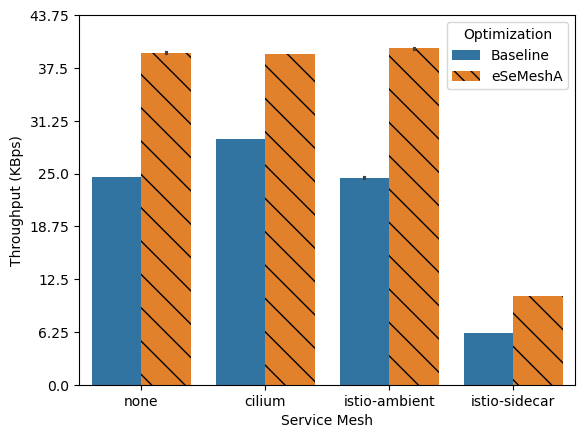

In [42]:
g = sns.barplot(data=ping_echo, y='throughput', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Throughput (KBps)',
    yticklabels=[format_data_size(tick, 'b', 'KB') for tick in g.get_yticks()],
)

g.legend(title='Optimization', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-throughput.svg', bbox_inches='tight', metadata={'Date': None})

In [43]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25    p50    avg    p75
Service Mesh  Mode                                
none          Baseline   97.7  121.4  139.8  157.8
              eSeMeshA   60.6   73.5   91.2   97.5
cilium        Baseline   83.0  102.0  118.5  134.3
              eSeMeshA   60.9   73.8   91.4   97.3
istio-ambient Baseline   98.8  122.0  140.5  158.6
              eSeMeshA   59.8   72.4   91.1   96.3
istio-sidecar Baseline  406.5  495.6  551.5  615.3
              eSeMeshA  236.1  287.4  320.4  359.5

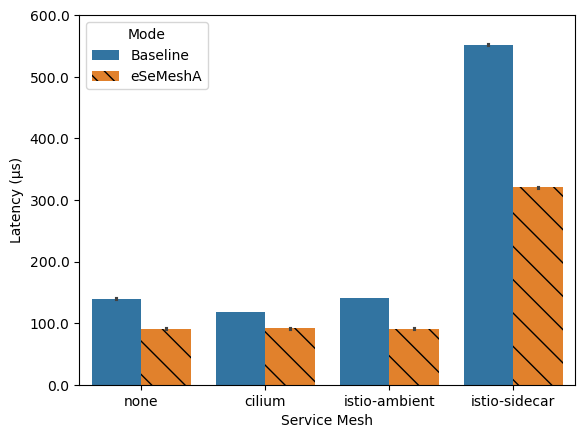

In [44]:
g = sns.barplot(data=ping_echo, y='latency', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Latency (µs)',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-latency.svg', bbox_inches='tight', metadata={'Date': None})

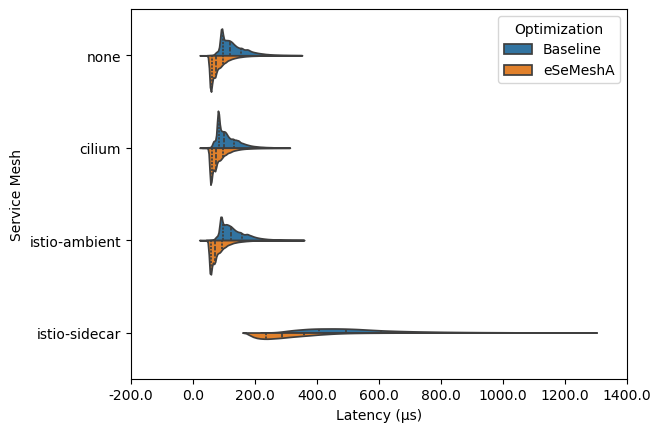

In [45]:
p99 = ping_echo.groupby('service_mesh').latency.transform(lambda x: x.quantile(0.99))

g = sns.violinplot(data=ping_echo[ping_echo.latency.lt(p99)], x='latency', y='service_mesh', hue='optimization', split=True, inner='quart', cut=0, order=service_mesh_order, hue_order=optimization_order)

g.set_xticks(g.get_xticks().tolist())
g.set(
    #title='',
    ylabel='Service Mesh',
    xlabel='Latency (µs)',
    xticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_xticks()],
)

g.legend(title='Optimization', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

g.figure.savefig('ping-echo-violinplot-latency-p99.svg', bbox_inches='tight', metadata={'Date': None})

In [46]:
summary = ping_echo_extra.groupby(['service_mesh', 'optimization'])['jitter'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25    p50    avg    p75
Service Mesh  Mode                                
none          Baseline   95.2   96.0   96.1   96.6
              eSeMeshA   92.3   95.8   94.7   97.3
cilium        Baseline   87.6   87.9   87.9   89.2
              eSeMeshA   96.0   97.4  101.3   99.4
istio-ambient Baseline   99.8  102.3  101.6  103.3
              eSeMeshA   94.7  103.9  110.9  104.5
istio-sidecar Baseline  276.7  278.3  278.5  279.3
              eSeMeshA  171.8  179.1  178.8  180.0

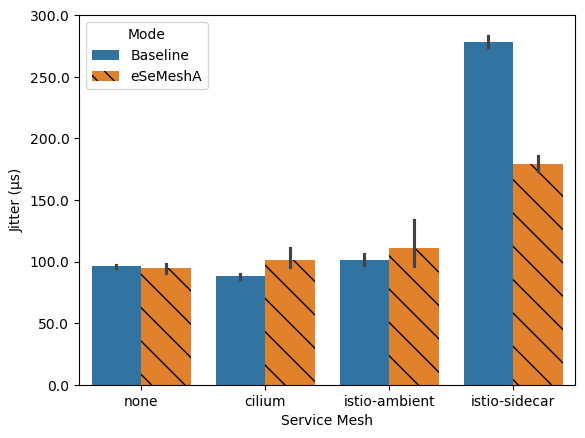

In [47]:
g = sns.barplot(data=ping_echo_extra, y='jitter', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Jitter (µs)',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-jitter.svg', bbox_inches='tight', metadata={'Date': None})

In [48]:
summary = ping_echo_extra.groupby(['service_mesh', 'optimization'])['fct'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25   p50   avg   p75
Service Mesh  Mode                            
none          Baseline  14.5  14.8  14.6  14.8
              eSeMeshA   9.5   9.7   9.6   9.7
cilium        Baseline  12.3  12.4  12.5  12.6
              eSeMeshA   9.6   9.6   9.6   9.7
istio-ambient Baseline  14.7  14.7  14.8  14.8
              eSeMeshA   9.5   9.6   9.6   9.6
istio-sidecar Baseline  55.2  56.1  56.3  57.8
              eSeMeshA  32.8  33.0  32.9  33.1

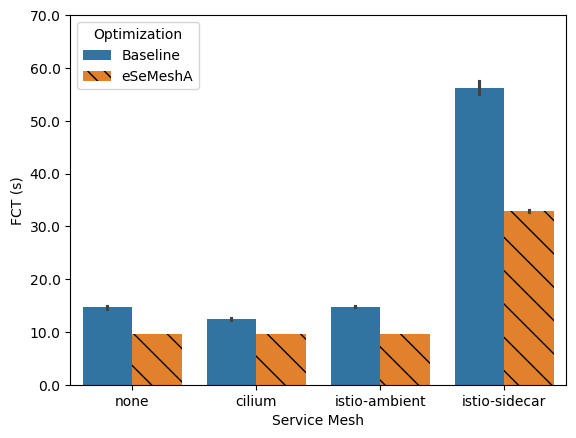

In [49]:
g = sns.barplot(data=ping_echo_extra, y='fct', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT (s)',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

g.legend(title='Optimization', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-fct.svg', bbox_inches='tight', metadata={'Date': None})

In [50]:
summary_latency = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    #std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 'us'))

summary_jitter = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    #avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 'us'))

summary_rps = ping_echo.groupby(['service_mesh', 'optimization'])['RPS'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
)

summary_fct = ping_echo_extra.groupby(['service_mesh', 'optimization'])['fct'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 's'))

summary_cpu = cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    total=lambda x: x.iloc[0],
    #p75=lambda x: x.quantile(.75),
    #std=lambda x: x.std(ddof=0),
)

summary_memory = memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_data_size(x, 'B', 'MB'))

summary = pd.DataFrame({
    'Latency (µs)': summary_value(summary_latency, 'avg', index=1).value,
    'Jitter (µs)': summary_value(summary_jitter, 'std', index=1).value,
    'RPS': summary_value(summary_rps, 'avg', index=1).value,
    'FCT (s)': summary_value(summary_fct, 'avg', index=1).value,
    'CPU (s)': summary_value(summary_cpu, 'total', index=1).value,
    'Memory (MB)': summary_value(summary_memory, 'avg', index=1).value,
})
summary = set_index_order(summary)

summary
#print_latex(summary)

Latency (µs)     Jitter (µs)              RPS  \
Service Mesh  Mode                                                        
none          Baseline           139.8            96.1           8186.1   
              eSeMeshA   91.2 (-34.8%)    94.8 (-1.4%)  13104.6 (60.1%)   
cilium        Baseline           118.5            88.0           9685.2   
              eSeMeshA   91.4 (-22.9%)   101.7 (15.6%)  13058.0 (34.8%)   
istio-ambient Baseline           140.5           101.8           8172.3   
              eSeMeshA   91.1 (-35.2%)   113.4 (11.4%)  13274.4 (62.4%)   
istio-sidecar Baseline           551.5           278.9           2049.1   
              eSeMeshA  320.4 (-41.9%)  179.0 (-35.8%)   3502.1 (70.9%)   

                              FCT (s)         CPU (s)    Memory (MB)  
Service Mesh  Mode                                                    
none          Baseline           14.6           110.5         1380.2  
              eSeMeshA   9.6 (-34.4%)   92.6 (-16.2%)  1411.4 (2.3%)  
cilium        Baseline           12.5           104.9         1325.7  
              eSeMeshA   9.6 (-22.7%)   92.3 (-12.1%)  1352.4 (2.0%)  
istio-ambient Baseline           14.8           132.2         1660.7  
              eSeMeshA   9.6 (-34.9%)  103.2 (-21.9%)  1677.7 (1.0%)  
istio-sidecar Baseline           56.3           357.8         1645.7  
              eSeMeshA  32.9 (-41.5%)  274.7 (-23.2%)  1667.6 (1.3%)

# redis

In [51]:
redis_raw = pd.DataFrame(logs['workload_logs']['redis'])
redis_raw = redis_raw.apply(lambda x: pd.concat([x.drop('meta'), pd.json_normalize(x.meta).iloc[0]]), axis=1)

In [52]:
redis = redis_raw[redis_raw.type.eq('metrics')].drop(['iteration', 'type'], axis=1).explode('data', ignore_index=True)
redis = redis.apply(lambda x: pd.concat([x.drop('data'), pd.Series({} if pd.isna(x.data) else x.data)]), axis=1)
redis['took'] = redis.took.apply(lambda x: pd.NA if pd.isna(x) else int(x))
redis = redis.map(lambda x: pd.NA if pd.isna(x) else x) \
    .astype({'took': 'Int64', 'latency_avg': 'Float64', 'ops_avg': 'Float64', 'throughput_avg': 'Float64'})

In [53]:
redis.head()

,cni,optimization,service_mesh,workload,iteration,took,ops_avg,throughput_avg,latency_avg
0,calico,disabled,istio-ambient,redis,1,19000000000,50057.0,17364418.6,1990000.0
1,calico,disabled,istio-ambient,redis,2,20000000000,48279.0,16777216.0,2070000.0
2,calico,disabled,istio-ambient,redis,3,20000000000,48255.0,16777216.0,2070000.0
3,calico,disabled,istio-ambient,redis,4,20000000000,48781.0,16944988.2,2050000.0
4,calico,disabled,istio-ambient,redis,5,20000000000,48314.0,16777216.0,2070000.0


In [54]:
hgrm_quantile = lambda df, q: df[df.percentile.ge(q)].iloc[0]

In [55]:
redis_hist = redis_raw[redis_raw.type.eq('histogram')].drop('type', axis=1)
def redis_hist_transform(x):
    ret = pd.read_csv(io.StringIO(x.data), sep=' +', engine='python').drop(columns='1/(1-Percentile)').rename(columns={'Value': 'latency', 'Percentile': 'percentile', 'TotalCount': 'total_count'})
    ret = x.drop('data').to_frame().T.join(ret, how='cross')
    ret['total_count_diff'] = ret.total_count - ret.total_count.shift(1, fill_value=0)
    return ret
redis_hist = redis_hist.apply(redis_hist_transform, axis=1)
redis_hist = pd.concat(redis_hist.tolist(), ignore_index=True)

In [56]:
redis_hist.head()

,cni,iteration,optimization,service_mesh,workload,latency,percentile,total_count,total_count_diff
0,calico,3,disabled,istio-ambient,redis,4.7e-02,0.0e+00,2,2
1,calico,3,disabled,istio-ambient,redis,1.2e+00,5.0e-02,51144,51142
2,calico,3,disabled,istio-ambient,redis,1.4e+00,1.0e-01,100043,48899
3,calico,3,disabled,istio-ambient,redis,1.4e+00,1.5e-01,150213,50170
4,calico,3,disabled,istio-ambient,redis,1.5e+00,2.0e-01,205650,55437


In [57]:
hgrm_quantile(redis_hist, .5)

cni                        calico
iteration                       3
optimization             disabled
service_mesh        istio-ambient
workload                    redis
latency                       1.7
percentile                    0.5
total_count                503018
total_count_diff            45321
Name: 10, dtype: object

In [58]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('redis')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25     p50     avg     p75
Service Mesh  Mode                                    
none          Baseline  1393.1  1464.2  1442.0  1479.4
              eSeMeshA  1466.1  1525.5  1503.4  1537.9
cilium        Baseline  1333.3  1428.9  1392.9  1434.9
              eSeMeshA  1414.9  1477.6  1452.4  1485.8
istio-ambient Baseline  1637.8  1742.0  1705.2  1759.7
              eSeMeshA  1738.9  1802.5  1773.6  1813.3
istio-sidecar Baseline  1765.3  1788.3  1769.7  1813.9
              eSeMeshA  1813.4  1836.1  1816.5  1860.8

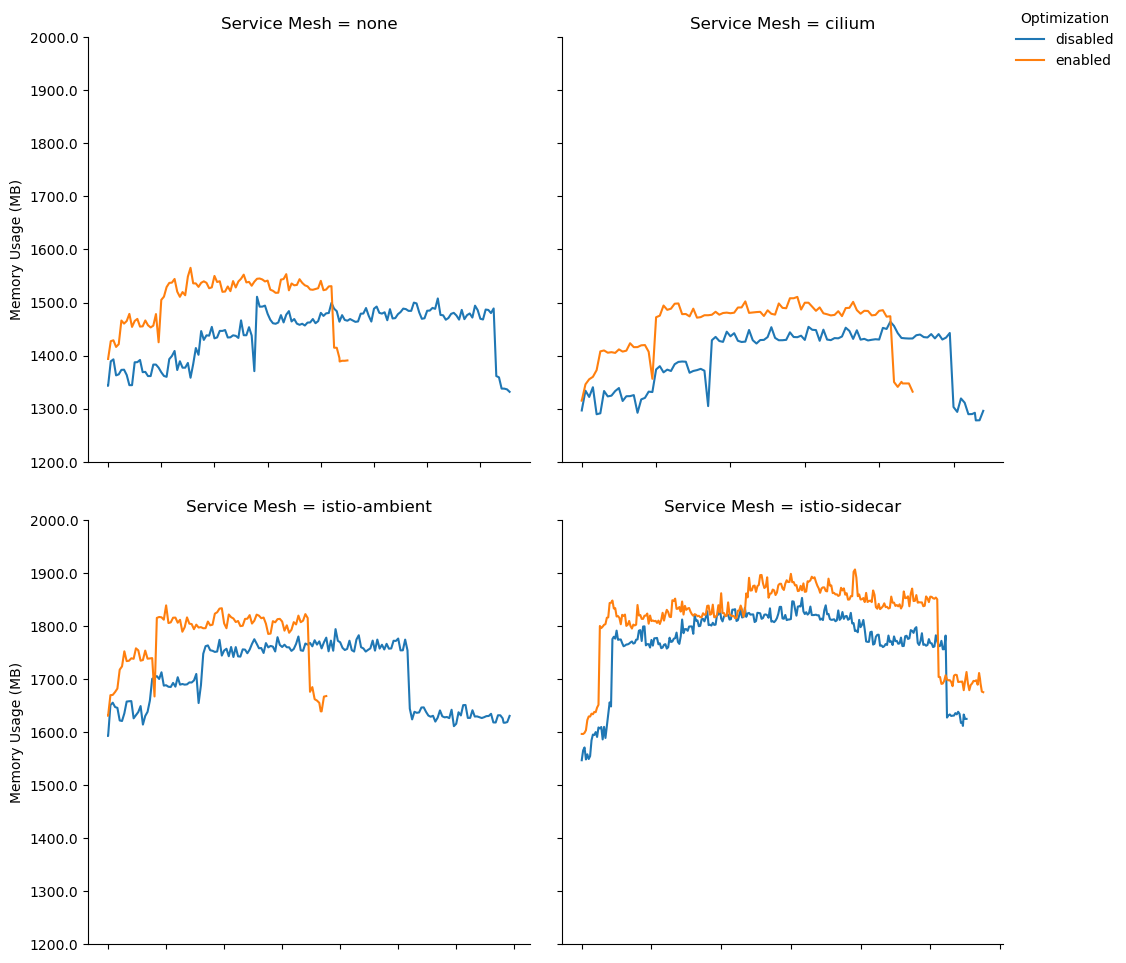

In [59]:
g = sns.relplot(kind='line', data=memory_used_bytes[memory_used_bytes.workload.eq('redis')], y='value', x='elapsed', hue='optimization', col='service_mesh', col_order=service_mesh_order, col_wrap=2, facet_kws={'sharey': True, 'sharex': False})

for ax in g.axes:
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set(
        title=ax.get_title().replace('service_mesh', 'Service Mesh'),
        xlabel='',
        ylabel='Memory Usage (MB)',
        yticklabels=[format_data_size(tick, 'B', 'MB') for tick in ax.get_yticks()],
        xticklabels=[],
    )

g.legend.set(title='Optimization', loc='upper right')
#g.get_legend().set_visible(False)
g.figure.savefig('redis-relplot-line-memory-used-bytes.svg', bbox_inches='tight', metadata={'Date': None})

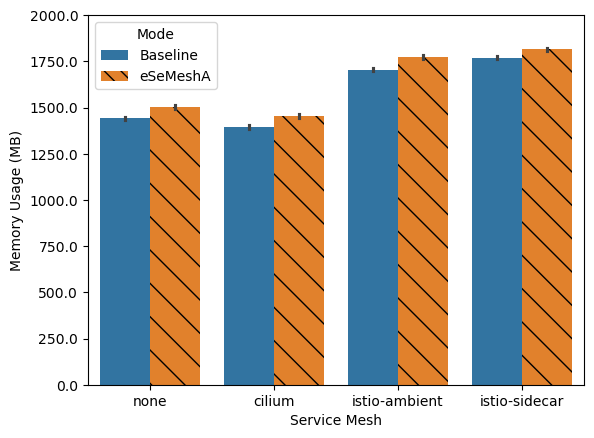

In [60]:
g = sns.barplot(data=memory_used_bytes[memory_used_bytes.workload.eq('redis')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Memory Usage (MB)',
    yticklabels=[format_data_size(tick, 'B', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('redis-barplot-memory-usage.svg', bbox_inches='tight', metadata={'Date': None})

In [61]:
summary = redis.groupby(['service_mesh', 'optimization'])['ops_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
)
summary = set_index_order(summary)

summary
#print_latex(summary)

p25      p50      avg      p75
Service Mesh  Mode                                        
none          Baseline  47902.0  48005.0  48248.8  48594.0
              eSeMeshA  69583.0  70765.0  70342.8  71096.0
cilium        Baseline  69571.0  70428.0  70332.6  70701.0
              eSeMeshA  70866.0  71332.0  71566.4  71756.0
istio-ambient Baseline  48279.0  48314.0  48737.2  48781.0
              eSeMeshA  67252.0  67290.0  67553.6  67577.0
istio-sidecar Baseline  17450.0  17528.5  17542.5  17621.0
              eSeMeshA  17072.8  17232.0  17305.2  17464.5

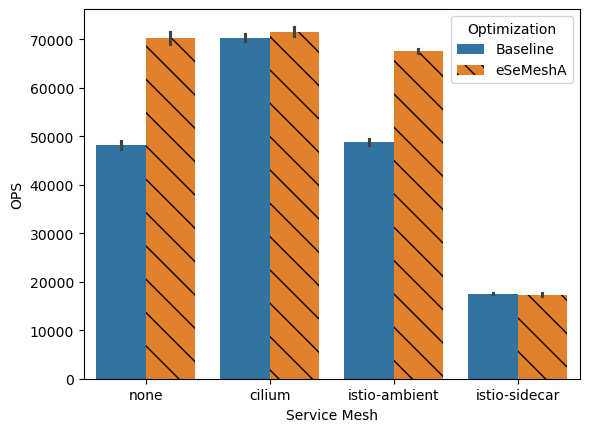

In [62]:
g = sns.barplot(data=redis, y='ops_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='OPS',
    #yticklabels=[],
)

g.legend(title='Optimization', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('redis-barplot-ops.svg', bbox_inches='tight', metadata={'Date': None})

In [63]:
summary = redis.groupby(['service_mesh', 'optimization'])['throughput_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'b', 'MB'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25  p50  avg  p75
Service Mesh  Mode                        
none          Baseline  2.1  2.1  2.1  2.1
              eSeMeshA  3.0  3.1  3.1  3.1
cilium        Baseline  3.0  3.1  3.1  3.1
              eSeMeshA  3.1  3.1  3.1  3.1
istio-ambient Baseline  2.1  2.1  2.1  2.1
              eSeMeshA  2.9  2.9  2.9  2.9
istio-sidecar Baseline  0.8  0.8  0.8  0.8
              eSeMeshA  0.7  0.7  0.8  0.8

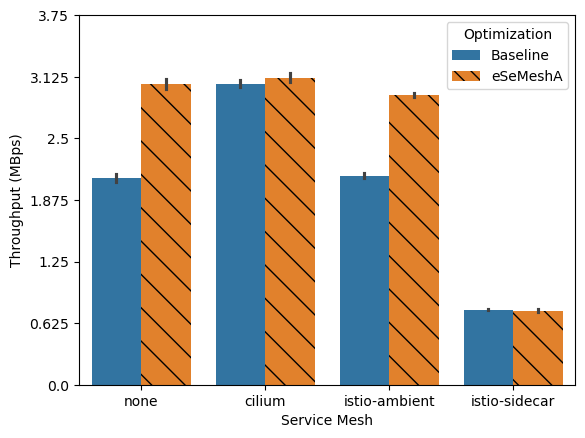

In [64]:
g = sns.barplot(data=redis, y='throughput_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Throughput (MBps)',
    yticklabels=[format_data_size(tick, 'b', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Optimization', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('redis-barplot-throughput.svg', bbox_inches='tight', metadata={'Date': None})

In [65]:
summary = redis.groupby(['service_mesh', 'optimization'])['latency_avg'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'ms'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25  p50  avg  p75
Service Mesh  Mode                        
none          Baseline  2.0  2.1  2.1  2.1
              eSeMeshA  1.4  1.4  1.4  1.4
cilium        Baseline  1.4  1.4  1.4  1.4
              eSeMeshA  1.4  1.4  1.4  1.4
istio-ambient Baseline  2.0  2.1  2.0  2.1
              eSeMeshA  1.5  1.5  1.5  1.5
istio-sidecar Baseline  5.7  5.7  5.7  5.7
              eSeMeshA  5.7  5.8  5.8  5.8

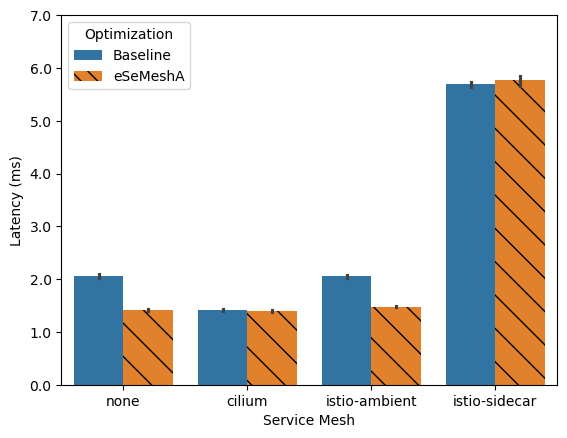

In [66]:
g = sns.barplot(data=redis, y='latency_avg', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='Latency (ms)',
    yticklabels=[format_time(tick, 'ns', 'ms') for tick in g.get_yticks()],
)

g.legend(title='Optimization', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('redis-barplot-latency.svg', bbox_inches='tight', metadata={'Date': None})

In [67]:
summary = redis.groupby(['service_mesh', 'optimization'])['took'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 's'))
summary = set_index_order(summary)

summary
#print_latex(summary)

p25   p50   avg   p75
Service Mesh  Mode                            
none          Baseline  20.0  20.0  20.2  20.0
              eSeMeshA  14.0  14.0  13.8  14.0
cilium        Baseline  14.0  14.0  13.8  14.0
              eSeMeshA  13.0  14.0  13.6  14.0
istio-ambient Baseline  20.0  20.0  19.8  20.0
              eSeMeshA  14.0  14.0  14.0  14.0
istio-sidecar Baseline  56.0  56.5  56.5  57.0
              eSeMeshA  56.8  57.5  57.2  58.0

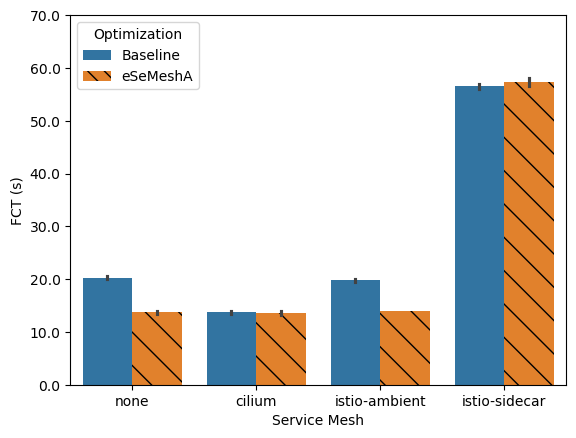

In [68]:
g = sns.barplot(data=redis, y='took', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    #title='',
    xlabel='Service Mesh',
    ylabel='FCT (s)',
    yticklabels=[format_time(tick, 'ns', 's') for tick in g.get_yticks()],
)

g.legend(title='Optimization', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('redis-barplot-fct.svg', bbox_inches='tight', metadata={'Date': None})

In [69]:
redis_hist.head()

,cni,iteration,optimization,service_mesh,workload,latency,percentile,total_count,total_count_diff
0,calico,3,disabled,istio-ambient,redis,4.7e-02,0.0e+00,2,2
1,calico,3,disabled,istio-ambient,redis,1.2e+00,5.0e-02,51144,51142
2,calico,3,disabled,istio-ambient,redis,1.4e+00,1.0e-01,100043,48899
3,calico,3,disabled,istio-ambient,redis,1.4e+00,1.5e-01,150213,50170
4,calico,3,disabled,istio-ambient,redis,1.5e+00,2.0e-01,205650,55437


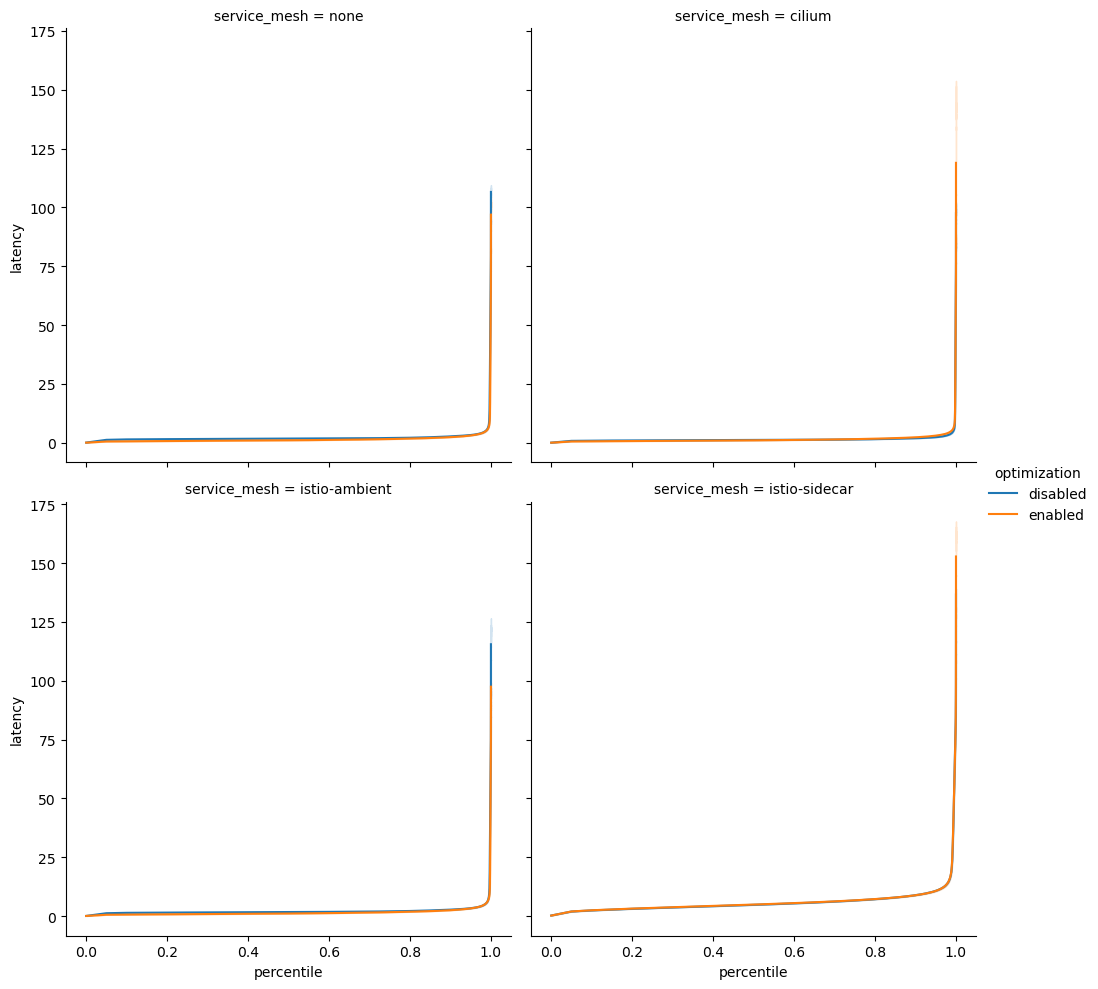

In [70]:
g = sns.relplot(
    data=redis_hist, x='percentile', y='latency',
    col='service_mesh', col_wrap=2, col_order=service_mesh_order, hue='optimization',
    kind='line'
)

#for ax in g.axes:
#    service_mesh = ax.get_title().replace('service_mesh = ', '')
#    ax.set_title(f'Service Mesh = {service_mesh}')
#    p99 = hgrm_quantile(redis_hist[redis_hist.service_mesh.eq(service_mesh)], .99).latency
#    ax.axvline(.99, linestyle='--', color='r', label=f'{service_mesh} = {p99}')

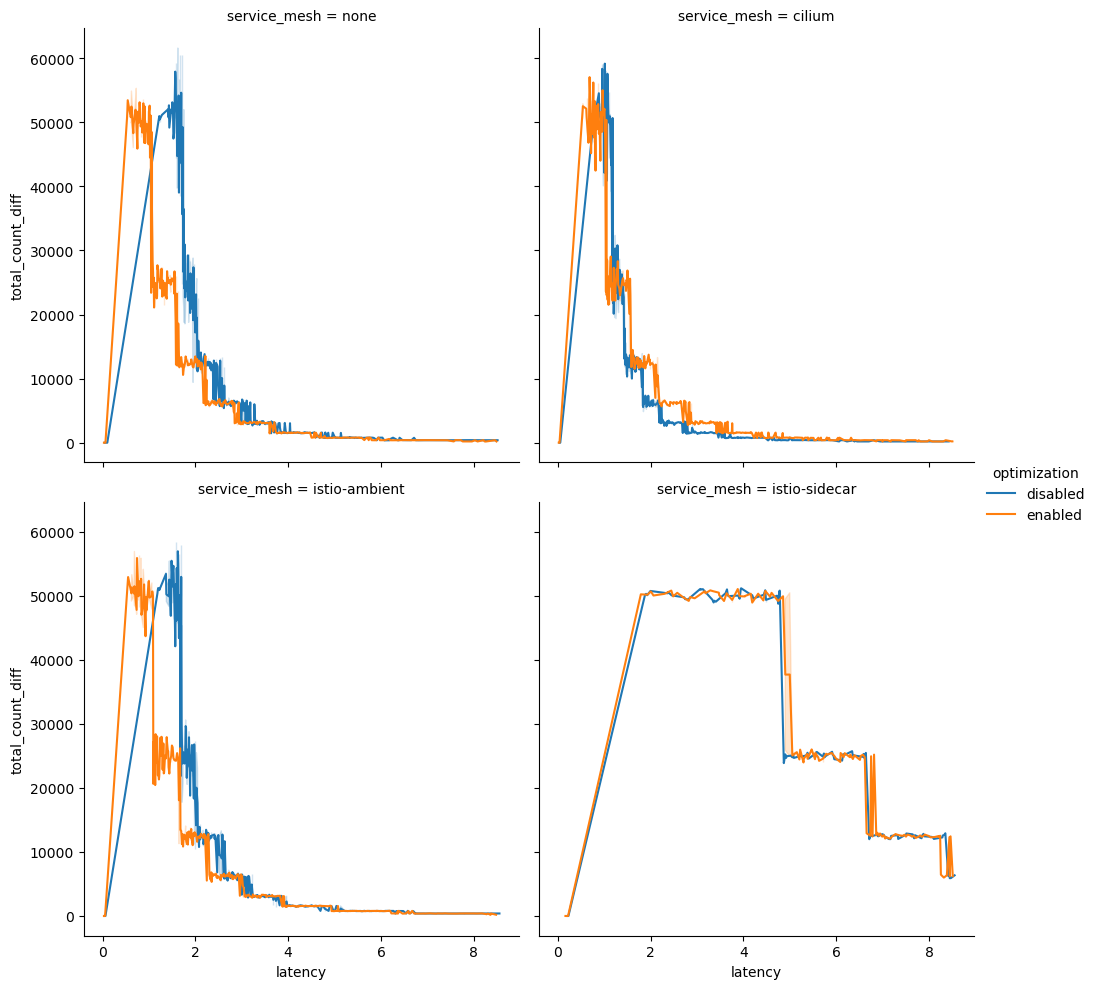

In [71]:
sns.relplot(
    data=redis_hist[redis_hist.latency.le(hgrm_quantile(redis_hist, .995).latency)], y='total_count_diff', x='latency',
    col='service_mesh', col_wrap=2, col_order=service_mesh_order, hue='optimization',
    kind='line'
)